# 利用TAO训练目标检测模型：SSD-resnet18


<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080">

## 实验目标
本次实验，会有以下主要内容:

* 从NGC下载预训练模型：resnet18，并利用Pascal VOC数据集来训练SSD-resnet18模型。
* 将SSD模型进行剪枝
* 将剪枝的模型再训练
* 导出剪枝过得模型


## 执行步骤（对应"黑客松知识图谱"的编号）

C22. [设置训练环境和路径](#head-0)<br>
C221. [安装TAO的加载器](#head-1)<br>
C24. [准备数据集和预训练模型](#head-2) <br>
C25. [下载预训练模型](#head-2-1) <br>
C26. [定义执行设置](#head-3)<br>
C27. [利用TAO开始训练](#head-4)<br>
C271. [评估训练结果](#head-5)<br>
C28. [模型剪枝](#head-6)<br>
C281. [对剪枝后的模型重新训练](#head-7)<br>
C282. [评估重新训练后的模型](#head-8)<br>
C29. [可视化推理结果](#head-9)<br>
C210. [模型导出](#head-10)<br>
C211. [验证模型部署](#head-11)<br>

## C22. 设置训练环境和路径 <a class="anchor" id="head-0"></a>

1. 当我们使用训练模型的时候，需要从NGC官网申请一个API Key，这个Key将和您训练的模型进行绑定！
2. Tao Toolkit可以直接在您计算机系统的环境下执行，它会自动启动docker，并加载相关工具。
3. 为了兼容于Docker版，这里需要配置两套路径系统，然后在下面步骤中进行映射：   
* LOCAL_PROJECT_DIR --> 您计算机系统中的实验文档存放地址  
* USER_EXPERIMENT_DIR --> docker系统中的实验文档存放地址

在下面的步骤中会将他们形成映射，您只需要操作你计算机系统中地址就好，无需管理docker系统中的地址

In [1]:
# C22：环境变量与路径设置.
import os

#  输入您在 NGC 申请的 API Key
%env KEY=
#  下面输入您的完整工作路径，不能使用$HOME之类的变量方式，可以使用下面的 "!pwd" 检查目前完整路径，
#  例如为  /home/user/hackathon/tao/ssd_cn,  则下面 参数就设为 /home/user/hackathon/tao
!pwd
%env LOCAL_PROJECT_DIR=
# 下面路径只有最后一个需要根据您所使用的神经网络名称进行修改，前面的/workspace/tao-experiments不变
%env USER_EXPERIMENT_DIR=/workspace/tao-experiments/ssd_cn
#  下一个路径就是以前一个 USER_EXPERIMENT_DIR 内容最后加上 /specs 就可以
%env SPECS_DIR=/workspace/tao-experiments/ssd_cn/specs
#  设定计算所使用的GPU编号
%env GPU_INDEX=0

# 下面的内容就不用修改
%env DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
os.environ["LOCAL_DATA_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "data")
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "ssd_cn")
# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=/home/user0/1_dl2t/tao_work/0_skyHackthon/ssd-resnet18_Tao_Ken_He/ssd/
# data/tlt-experiments/ssd
# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)

# 检查是否能找到 LOCAL_SPECS_DIR 所指的内容
!ls -rlt $LOCAL_SPECS_DIR

env: KEY=cTJhcms3ODdvbHRsOWwxMTNvYW0yN3NuaHA6MTQwZWE4YmMtNzAxNS00NzhjLTliNzgtZGRhNzY2NDJhMWM0
/home/user0/1_dl2t/hackathon/tao/ssd_cn
env: LOCAL_PROJECT_DIR=/home/user0/1_dl2t/hackathon/tao/
env: USER_EXPERIMENT_DIR=/workspace/tao-experiments/ssd_cn
env: SPECS_DIR=/workspace/tao-experiments/ssd_cn/specs
env: GPU_INDEX=0
env: DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
总用量 28
-rw-rw-r-- 1 user0 user0  1675 8月  24 23:51 ssd_train_resnet18_kitti_seq.txt
-rw-rw-r-- 1 user0 user0  1659 8月  24 23:51 ssd_retrain_resnet18_kitti_seq.txt
-rw-rw-r-- 1 user0 user0   536 10月 27 13:46 ssd_tfrecords_kitti_train.txt
-rw-rw-r-- 1 user0 user0  1498 10月 27 13:53 ssd_train_resnet18_kitti.txt
-rw-rw-r-- 1 user0 user0  1482 10月 28 10:08 ssd_retrain_resnet18_kitti.txt
-rw-rw-r-- 1 user0 docker 1499 10月 28 22:48 ssd_train_resnet101_kitti.txt
-rw-rw-r-- 1 user0 docker 1498 10月 29 08:42 ssd_train_resnet34.txt


### C224-2. 接下来要将两组路径进行 docker 映射
* LOCAL_PROJECT_DIR 映射到容器的 /workspace/tao-experiments
* LOCAL_SPECS_DIR       映射到容器的 SPECS_DIR

In [47]:
# C22：路径映射，下面内容不需要做修改！
import json
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tao-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ]
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)
    
!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/user0/1_dl2t/hackathon/tao/",
            "destination": "/workspace/tao-experiments"
        },
        {
            "source": "/home/user0/1_dl2t/hackathon/tao/ssd_cn/specs",
            "destination": "/workspace/tao-experiments/ssd_cn/specs"
        }
    ]
}

### C221. 安装TAO的加载器： <a class="anchor" id="head-1"></a>**如果已经安装过就不需要再执行**
下面的步骤是安装TAO Python接口的步骤。

In [ ]:
# 如果您已经安装好了，则不需要执行这一步
!pip3 install nvidia-pyindex
!pip3 install nvidia-tao

In [3]:
# 查看当前环境下TAO的信息
!tao info

Configuration of the TAO Toolkit Instance
dockers: ['nvidia/tao/tao-toolkit-tf', 'nvidia/tao/tao-toolkit-pyt', 'nvidia/tao/tao-toolkit-lm']
format_version: 1.0
toolkit_version: 3.21.08
published_date: 08/17/2021


## C23. 准备数据集和预训练模型 <a class="anchor" id="head-2"></a>
-  本范例使用的Pascal Voc数据集，需要将先将标注文件格式转换成Kitti的数据标注格式

### C231. 将数据集内容复制到制定目录
-  将图片数据集（例如`<images>`）和标注文件（例如`<labels>`）复制到  `$LOCAL_DATA_DIR ` 下
-  这里的 `$LOCAL_DATA_DIR` 在前面的处理中设置为 `$LOCAL_PROJECT_DIR/`data
-  本范例的 `$LOCAL_PROJECT_DIR` = /home/user/hackathon/tao， 
-  因此此时 `$LOCAL_DATA_DIR`          = /home/user/hackathon/tao/data

In [7]:
# 检查   $LOCAL_DATA_DIR
!ls -l $LOCAL_DATA_DIR/

总用量 756
drwxrwxr-x 2 user0 user0 376832 11月 11 12:50 images
drwxrwxr-x 2 user0 user0 389120 11月 11 12:50 labels
drwxrwxr-x 4 user0 user0   4096 11月 11 12:50 val


### C232：生成验证数据集，
用 generate_val_dataset.py 将图片数据格式后缀名修改成跟您图片数据格式一样。</br>
原文中使用的是.png格式的后缀名。</br>
此时generate_val_dataset.py的参数需要的文件夹地址均为您的计算机系统本地地址，不是docker中的地址。

In [8]:
!python3.6 generate_val_dataset.py --input_image_dir=$LOCAL_DATA_DIR/images \
                                   --input_label_dir=$LOCAL_DATA_DIR/labels \
                                   --output_dir=$LOCAL_DATA_DIR/val

This script will not run as output image path already exists.


### C233 数据转换格式：将KITTI格式转换成tf_records格式
可以在 Jupyter 里直接打开 `$LOCAL_SPECS_DIR/ssd_tfrecords_kitti_train.txt` 进行修改，</br>
实际位置为`<工作目录>/specs/ssd_tfrecords_kitti_train.txt`
1. `root_directory_path` ：作为数据集格式转换的工作根目录，以 docker 环境中的地址格式，</br>
例如 "root_directory_path:"/workspace/tao-experiments/data" 
2. `image_dir_name`：用前面根目录为起点的图像目录，例如 image_dir_name:"images"
3. `label_dir_name`：用前面根目录为起点的标签目录，例如 label_dir_name:"labels"
4. `image_directory_path` 和`root_directory_path`可以理解为一样。
5. `target_class_mapping`采用<key:value>对的方式定义标注的类别，</br>key为标注文件中写的类别，value为Tao训练时使用的类别名字

In [15]:
print("修改 TFRecords 转换的配置文件，内容显示如下：")
!cat $LOCAL_SPECS_DIR/ssd_tfrecords_kitti_train.txt

修改 TFRecords 转换的配置文件，内容显示如下：
kitti_config {
  root_directory_path: "/workspace/tao-experiments/data"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 0
  num_shards: 10
}
image_directory_path: "/workspace/tao-experiments/abc"
target_class_mapping {
    key: "cat"
    value: "cat"
}
target_class_mapping {
    key: "person"
    value: "person"
}
target_class_mapping {
    key: "dog"
    value: "dog"
}
target_class_mapping {
    key: "horse"
    value: "horse"
}

In [17]:
# C233 创建保存 tfrecord 格式的文件夹，并利用Tao自带的工具转换数据。
# 数据将被保存在 -o 后面的文件目录里面。
print("将训练数据集转换成 TFRecords 格式.")
!mkdir -p $LOCAL_DATA_DIR/tfrecords && rm -rf $LOCAL_DATA_DIR/tfrecords/*
!tao ssd dataset_convert \
         -d $SPECS_DIR/ssd_tfrecords_kitti_train.txt \
         -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_train 
# 检查生成的结果
!ls -rlt $LOCAL_DATA_DIR/tfrecords/

将训练数据集转换成 TFRecords 格式.
2021-11-11 16:15:52,947 [INFO] root: Registry: ['nvcr.io']
2021-11-11 16:15:53,103 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/user0/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-11 08:16:03,844 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-11-11 08:16:03,899 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 8653	Val: 0
2021-11-11 08:16:03,900 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Skipped validation data...
2021-11-11 08:16:03,913 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2021-11-11 08:16:03,913 - tensorflow - WARNING - Fr

## C24 从NGC下载预训练模型 <a class="anchor" id="head-2-1"></a>
我们将使用NGC CLI来得到预训练模型。详细信息可以访问[ngc.nvidia.com](ngc.nvidia.com)-->SETUP来了解

In [18]:
# C241：下载并安装NGC CLI，第一次运行的时候需要安装，如果已经安装了，那么可以跳过这一步
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli
## 移除旧版本 CLI 
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
## 在本机上下载并安装 NGC CLI
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/user0/.wget-hsts'. HSTS will be disabled.
--2021-11-11 16:28:08--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
正在解析主机 ngc.nvidia.com (ngc.nvidia.com)... 13.226.234.114, 13.226.234.57, 13.226.234.13, ...
正在连接 ngc.nvidia.com (ngc.nvidia.com)|13.226.234.114|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 25122135 (24M) [application/zip]
正在保存至: “/home/user0/1_dl2t/hackathon/tao//ngccli/ngccli_cat_linux.zip”

ngccli_cat_linux.zi 100%[===================>]  23.96M  11.6MB/s    用时 2.1s    

2021-11-11 16:28:11 (11.6 MB/s) - 已保存 “/home/user0/1_dl2t/hackathon/tao//ngccli/ngccli_cat_linux.zip” [25122135/25122135])

Archive:  /home/user0/1_dl2t/hackathon/tao//ngccli/ngccli_cat_linux.zip
  inflating: /home/user0/1_dl2t/hackathon/tao//ngccli/ngc  
 extracting: /home/user0/1_dl2t/hackathon/tao//ngccli/ngc.md5  


In [21]:
# C242：验证NGC的登录，如果不成功出可能是您没有开启NGC的验证，
#                  或者您的Key过时了，需要重新验证。如果下载成功，可以不必运行这一步。
!docker login nvcr.io

Authenticating with existing credentials...
WARNING! Your password will be stored unencrypted in /home/user0/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [20]:
# 如果上一步验证过成功，就跳过这一步
# 如果不成功就清理之前的验证，再重新运行上一步重新验证。
!ngc config clear

Successfully cleared NGC configuration /home/user0/.ngc/config


In [22]:
#查看目前NGC上可以下载的预训练模型，下面这个命令就是列出所有的目标检测的预训练模型
!ngc registry model list nvidia/tao/pretrained_object_detection:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 77.56 | 80    | 1     | V100  | 153.7 | 153.7 | UPLOA | Aug   |
|       |       |       |       |       |       | 2 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| vgg16 | 77.17 | 80    | 1     | V100  | 113.2 | 113.1 | UPLOA | Aug   |
|       |       |       |       |       |       | 6 MB  | D_COM | 18,   |
|       |       |       |       |       |       |       | PLETE | 2021  |
| squee | 65.13 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Aug   |
| zenet |       |       |       |     

In [25]:
#C243：创建文件夹（<工作目录>/pretrained_resnet18）保存下载的预训练模型
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

# 下载您所选择的预训练模型（pretrained_object_detection:resnet18 ）
!ngc registry model download-version nvidia/tao/pretrained_object_detection:resnet18 \
         --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18

#查看预训练模型是否下载成功
!ls -l $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/pretrained_object_detection_vresnet18

Downloaded 82.38 MB in 17m 4s, Download speed: 82.36 KB/s                
----------------------------------------------------
Transfer id: pretrained_object_detection_vresnet18 Download status: Completed.
Downloaded local path: /home/user0/1_dl2t/hackathon/tao/ssd_cn/pretrained_resnet18/pretrained_object_detection_vresnet18-1
Total files downloaded: 1 
Total downloaded size: 82.38 MB
Started at: 2021-11-11 16:38:42.561827
Completed at: 2021-11-11 16:55:46.857605
Duration taken: 17m 4s
----------------------------------------------------
总用量 91096
-rw------- 1 user0 user0 93278448 11月 11 16:35 resnet_18.hdf5


## C25. 调整模型训练的参数 <a class="anchor" id="head-3"></a>
可以在 Jupyter 里直接打开 `$LOCAL_SPECS_DIR/ssd_train_resnet18_kitti.txt` 进行修改，</br>
实际位置为`<工作目录>/specs/ssd_train_resnet18_kitti.txt`
1. 修改`target_class_mapping`为您需要训练的类别
2. 此处的路径基本不需要修改，除非您自己改动过。
3. `batch_size_per_gpu`定义batch_size大小，如果GPU显存不是很大，建议可以调整小一点，否则可能出现out of memory的错误
4. `num_epochs`定义要训练多少圈，如果是第一次训练，建议不要小于80
5. `validation_period_during_training`定义训练多少圈验证一次，可以直观地看出训练的效果变化，建议定义为5 或 10

In [ ]:
### 要启用QAT训练，请取消注释以下行
# !sed -i "s/enable_qat: false/enable_qat: true/g" $LOCAL_SPECS_DIR/ssd_train_resnet18_kitti.txt
# !sed -i "s/enable_qat: false/enable_qat: true/g" $LOCAL_SPECS_DIR/ssd_retrain_resnet18_kitti.txt

In [ ]:
### 默认情况下为关闭QAT训练。可以通过运行下面的行来强制非QAT培训
# !sed -i "s/enable_qat: true/enable_qat: false/g" $LOCAL_SPECS_DIR/ssd_train_resnet18_kitti.txt
# !sed -i "s/enable_qat: true/enable_qat: false/g" $LOCAL_SPECS_DIR/ssd_retrain_resnet18_kitti.txt

In [26]:
# 检查   $LOCAL_SPECS_DIR/ssd_train_resnet18_kitti.txt 内容
!cat $LOCAL_SPECS_DIR/ssd_train_resnet18_kitti.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.05, 0.1, 0.25, 0.4, 0.55, 0.7, 0.85]"
  two_boxes_for_ar1: true
  clip_boxes: false
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "resnet"
  nlayers: 18
  freeze_bn: false
  freeze_blocks: 0
}
training_config {
  batch_size_per_gpu: 32
  num_epochs: 80
  enable_qat: false
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-5
    max_learning_rate: 2e-2
    soft_start: 0.15
    annealing: 0.8
    }
  }
  regularizer {
    type: L1
    weight: 3e-5
  }
}
eval_config {
  validation_period_during_training: 5
  average_precision_mode: SAMPLE
  batch_size: 16
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
    output_width: 300
    output_height: 300
    output_channel: 3
}
dataset_config {
  data_sources: {
    tfrecords_path: "/workspace/tao-experiments/data/tfrecords/kitti_t

## C26. 开始利用TAO进行训练 <a class="anchor" id="head-4"></a>
只需要利用下面命令中的 tao ssd train 就可以训练
1. `--gpus`定义使用几个GPU，如果需要使用多个GPU，就修改这个参数后面的数量
2.`--gpu_index`定义了您用哪个GPU
3. ` -e`定义使用的训练设置文件
4. `-r` 定义训练的模型输出文件夹
5. `-k` 定义您使用的秘钥 API Key
6. `-m`定义所调用的预训练模型 ，这里使用前面从NGC下载的预训练模型

### 注意：这里可能会花费很长时间

In [27]:
# 创建模型输出文件夹，您训练的结果会保存在这里
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_unpruned
# 如果需要print("To run with multigpu, please change --gpus based on the number of available GPUs in your machine.")
!tao ssd train --gpus 1 --gpu_index=$GPU_INDEX \
               -e $SPECS_DIR/ssd_train_resnet18_kitti.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
               -k $KEY \
               -m $USER_EXPERIMENT_DIR/pretrained_resnet18/pretrained_object_detection_vresnet18/resnet_18.hdf5

In [ ]:
# 如果是上面没训练完，中途断开了，可以利用这里的命令在上面的基础上继续训练
print("To resume from checkpoint, please uncomment and run this instead. Change last two arguments accordingly.")
# !tao ssd train --gpus 1 --gpu_index=$GPU_INDEX \
#                -e $SPECS_DIR/ssd_train_resnet18_kitti.txt \
#                -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
#                -k $KEY \
#                -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_resnet18_epoch_001.tlt \
#                --initial_epoch 2

In [29]:
# 查看训练的模型
print('Model for each epoch:')
print('---------------------')
!ls -ltrh $LOCAL_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
总用量 8.0G
-rw-r--r-- 1 root root 103M 11月 11 17:07 ssd_resnet18_epoch_001.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:09 ssd_resnet18_epoch_002.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:10 ssd_resnet18_epoch_003.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:11 ssd_resnet18_epoch_004.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:12 ssd_resnet18_epoch_005.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:14 ssd_resnet18_epoch_006.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:15 ssd_resnet18_epoch_007.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:16 ssd_resnet18_epoch_008.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:17 ssd_resnet18_epoch_009.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:19 ssd_resnet18_epoch_010.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:20 ssd_resnet18_epoch_011.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:21 ssd_resnet18_epoch_012.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:23 ssd_resnet18_epoch_013.tlt
-rw-r--r-- 1 root root 103M 11月 11 17:24 ssd_resnet18_epoch_014

### C261：找出精度最好(mAP最高)的模型
用 Jupyter 的 "CSVTable" 工具查看 **experiment_dir_unpruned**/ssd_training_log_resnet18.csv,  </br>
找出精度最好的(倒数第二栏mAP最大)，</br>记录这个epoch值提供给下一步 %set_env EPOCH=

### C262. 评估训练的模型 <a class="anchor" id="head-5"></a>

In [31]:
# 例如上一步骤mAP最好的是第 80 个 epoch，则下面填入 '080'
%set_env EPOCH=
!tao ssd evaluate --gpu_index=$GPU_INDEX \
                  -e $SPECS_DIR/ssd_train_resnet18_kitti.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_resnet18_epoch_$EPOCH.tlt \
                  -k $KEY

env: EPOCH=080
2021-11-11 18:53:10,378 [INFO] root: Registry: ['nvcr.io']
2021-11-11 18:53:10,554 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/user0/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-11 10:53:21,747 [INFO] iva.ssd.utils.spec_loader: Merging specification from /workspace/tao-experiments/ssd_cn/specs/ssd_train_resnet18_kitti.txt

2021-11-11 10:53:21,752 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-11-11 10:53:21,752 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tenso

## C27. 对模型进行剪枝 <a class="anchor" id="head-6"></a>
1. `-pth`：这里主要利用调整`阈值(-pth)`来进行剪裁任务：
> pth越大剪去参数越多，模型越小，运行速度越快，但是可能精度越低</br>
> 需要反复试验，建议从0.5开始，如果模型剪裁效果一直不好，那么把0.5换成0.3
2. `-m` 定义您要剪枝的模型
3. `-o` 定义剪之后输出的模型
4. `-eq`定义剪枝的方式
5.  `-k` 定义您的秘钥API Key

In [32]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_pruned
!tao ssd prune --gpu_index=$GPU_INDEX \
               -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_resnet18_epoch_$EPOCH.tlt \
               -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_resnet18_pruned.tlt \
               -eq intersection \
               -pth 0.5 \
               -k $KEY

2021-11-11 18:58:43,434 [INFO] root: Registry: ['nvcr.io']
2021-11-11 18:58:43,600 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/user0/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-11 10:58:59,984 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2021-11-11 10:59:02,385 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2021-11-11 10:59:57,795 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.023385684124089506
2021-11-11 18:59:59,773 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


In [33]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_pruned/

总用量 1604
-rw-r--r-- 1 root root 1638864 11月 11 18:59 ssd_resnet18_pruned.tlt


### C271. 对剪枝后的模型重新训练 <a class="anchor" id="head-7"></a>
可以在 Jupyter 里直接打开 `$LOCAL_SPECS_DIR/ssd_retrain_resnet18_kitti.txt` 进行修改，</br>
实际位置为 <工作目录>/specs/**ssd_retrain_resnet18_kitti.txt**
1. 这个配置文件与C25的**ssd_train_resnet18_kitti.txt** 并非同一个配置文件
2. 修改的部分请参考 C25 的部分
3. 这里`-m`使用的预训练模型为前一步骤所剪裁过的模型

In [34]:
#查看重新训练的设置文件
!cat $LOCAL_SPECS_DIR/ssd_retrain_resnet18_kitti.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.05, 0.1, 0.25, 0.4, 0.55, 0.7, 0.85]"
  two_boxes_for_ar1: true
  clip_boxes: false
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "resnet"
  nlayers: 18
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 32
  num_epochs: 80
  enable_qat: false
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-5
    max_learning_rate: 2e-2
    soft_start: 0.1
    annealing: 0.6
    }
  }
  regularizer {
    type: NO_REG
    weight: 3e-9
  }
}
eval_config {
  validation_period_during_training: 5
  average_precision_mode: SAMPLE
  batch_size: 32
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
    output_width: 300
    output_height: 300
    output_channel: 3
}
dataset_config {
  data_sources: {
    tfrecords_path: "/workspace/tao-experiments/data/tfrecords/kitti_train*"
  }
  inc

In [ ]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_retrain
# 跟上面训练的步骤一样，只不过修改了预训练模型
!tao ssd train --gpus 1 --gpu_index=$GPU_INDEX \
               -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
               -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_resnet18_pruned.tlt \
               -k $KEY

2021-11-11 19:06:50,163 [INFO] root: Registry: ['nvcr.io']
2021-11-11 19:06:50,324 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/user0/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.

2021-11-11 11:07:01,027 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


2021-11-11 11:07:01,028 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2021-11-11 11:07:01,163 [WARNING] tensorflow: From /root/.cache/

In [39]:
# 查看训练结果
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_retrain/weights

总用量 451200
-rw-r--r-- 1 root root 5774584 11月 12 00:56 ssd_resnet18_epoch_001.tlt
-rw-r--r-- 1 root root 5774584 11月 12 00:57 ssd_resnet18_epoch_002.tlt
-rw-r--r-- 1 root root 5774584 11月 12 00:58 ssd_resnet18_epoch_003.tlt
-rw-r--r-- 1 root root 5774584 11月 12 00:58 ssd_resnet18_epoch_004.tlt
-rw-r--r-- 1 root root 5774584 11月 12 00:59 ssd_resnet18_epoch_005.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:00 ssd_resnet18_epoch_006.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:01 ssd_resnet18_epoch_007.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:01 ssd_resnet18_epoch_008.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:02 ssd_resnet18_epoch_009.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:03 ssd_resnet18_epoch_010.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:04 ssd_resnet18_epoch_011.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:04 ssd_resnet18_epoch_012.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:05 ssd_resnet18_epoch_013.tlt
-rw-r--r-- 1 root root 5774584 11月 12 01:06 ssd_resnet18_epoch_014

### C272：与C261同样的方式
用 Jupyter 的 "CSVTable" 工具查看 **experiment_dir_retrain**/ssd_training_log_resnet18.csv,  </br>
找出精度最好的(倒数第二栏mAP最大)，</br>记录这个epoch值提供给下一步 %set_env EPOCH=

### C273. 评估重新训练的模型 <a class="anchor" id="head-8"></a>
以mAP最好的模型文件编号，设置下面EPOCH值再执行评估<br>
***最后评估结果至少得超过 0.3，如果不足的话请重新回到 C27 调整剪裁***

In [40]:
#  先设定下面参数为mAP最好的模型
%set_env EPOCH=080
!tao ssd evaluate --gpu_index=$GPU_INDEX \
                  -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt \
                  -k $KEY

env: EPOCH=080
2021-11-12 08:52:58,262 [INFO] root: Registry: ['nvcr.io']
2021-11-12 08:52:58,424 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/user0/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-12 00:53:08,095 [INFO] iva.ssd.utils.spec_loader: Merging specification from /workspace/tao-experiments/ssd_cn/specs/ssd_retrain_resnet18_kitti.txt

2021-11-12 00:53:08,099 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-11-12 00:53:08,100 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/ten

## C28. 可视化推理结果（可省略）<a class="anchor" id="head-9"></a>
这个步骤利用上面训练好的模型进行推理，看看模型是否能够工作了，</br>
测试数据存放在工作根目录下的`<data/testimgs>`里

1. `-i` 指定存放测试图片的文件夹，这里使用Tao docker文件系统中的路径 `$DATA_DOWNLOAD_DIR/testimgs` 
2. `-o` 是输出文件夹，即检测过得图片保存的位置
3. `-e` 是您训练时用的文件
4. `-m` 是您要测试的模型
5. `-l` 是推理结果的标注文件
6. `-k` 是您的秘钥API Key

In [50]:
!tao ssd inference --gpu_index=$GPU_INDEX -i $DATA_DOWNLOAD_DIR/testimgs \
                   -o $USER_EXPERIMENT_DIR/ssd_infer_images \
                   -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
                   -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt \
                   -l $USER_EXPERIMENT_DIR/ssd_infer_labels \
                   -k $KEY

2021-11-12 09:53:15,476 [INFO] root: Registry: ['nvcr.io']
2021-11-12 09:53:15,624 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/user0/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-12 01:53:25,072 [INFO] iva.ssd.utils.spec_loader: Merging specification from /workspace/tao-experiments/ssd_cn/specs/ssd_retrain_resnet18_kitti.txt

2021-11-12 01:53:25,076 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-11-12 01:53:25,076 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend

下面的步骤就是将图片是在Jupyter上，您可以按照下面的步骤执行或者也可以直接打开保存的检测过得图片进行查看  
国内可能由于网络原因下载安装matplotlib会比较慢，如无必要，其实可以不执行下面的步骤

In [51]:
!pip3 --default-timeout=100 install matplotlib==3.3.3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 11.6 MB 104 kB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 193 kB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 507 kB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 232 kB/s eta 0:00:01
You should consider upgrading via the '/home/user0/.virtualenvs/launcher/bin/python -m pip install --upgrade pip' command.


In [52]:
# Simple grid visualizer
#!pip3 install matplotlib==3.3.3
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

In [53]:
!ls $LOCAL_EXPERIMENT_DIR/ssd_infer_images

000100.png  000150.png	cat100.jpg  cat150.jpg	dog100.jpg  dog150.jpg
000101.png  000151.png	cat101.jpg  cat151.jpg	dog101.jpg  dog151.jpg
000102.png  000152.png	cat102.jpg  cat152.jpg	dog102.jpg  dog152.jpg
000103.png  000153.png	cat103.jpg  cat153.jpg	dog103.jpg  dog153.jpg
000104.png  000154.png	cat104.jpg  cat154.jpg	dog104.jpg  dog154.jpg
000105.png  000155.png	cat105.jpg  cat155.jpg	dog105.jpg  dog155.jpg
000106.png  000156.png	cat106.jpg  cat156.jpg	dog106.jpg  dog156.jpg
000107.png  000157.png	cat107.jpg  cat157.jpg	dog107.jpg  dog157.jpg
000108.png  000158.png	cat108.jpg  cat158.jpg	dog108.jpg  dog158.jpg
000109.png  000159.png	cat109.jpg  cat159.jpg	dog109.jpg  dog159.jpg
000110.png  000160.png	cat110.jpg  cat160.jpg	dog110.jpg  dog160.jpg
000111.png  000161.png	cat111.jpg  cat161.jpg	dog111.jpg  dog161.jpg
000112.png  000162.png	cat112.jpg  cat162.jpg	dog112.jpg  dog162.jpg
000113.png  000163.png	cat113.jpg  cat163.jpg	dog113.jpg  dog163.jpg
000114.png  000164.png	cat114.jpg 

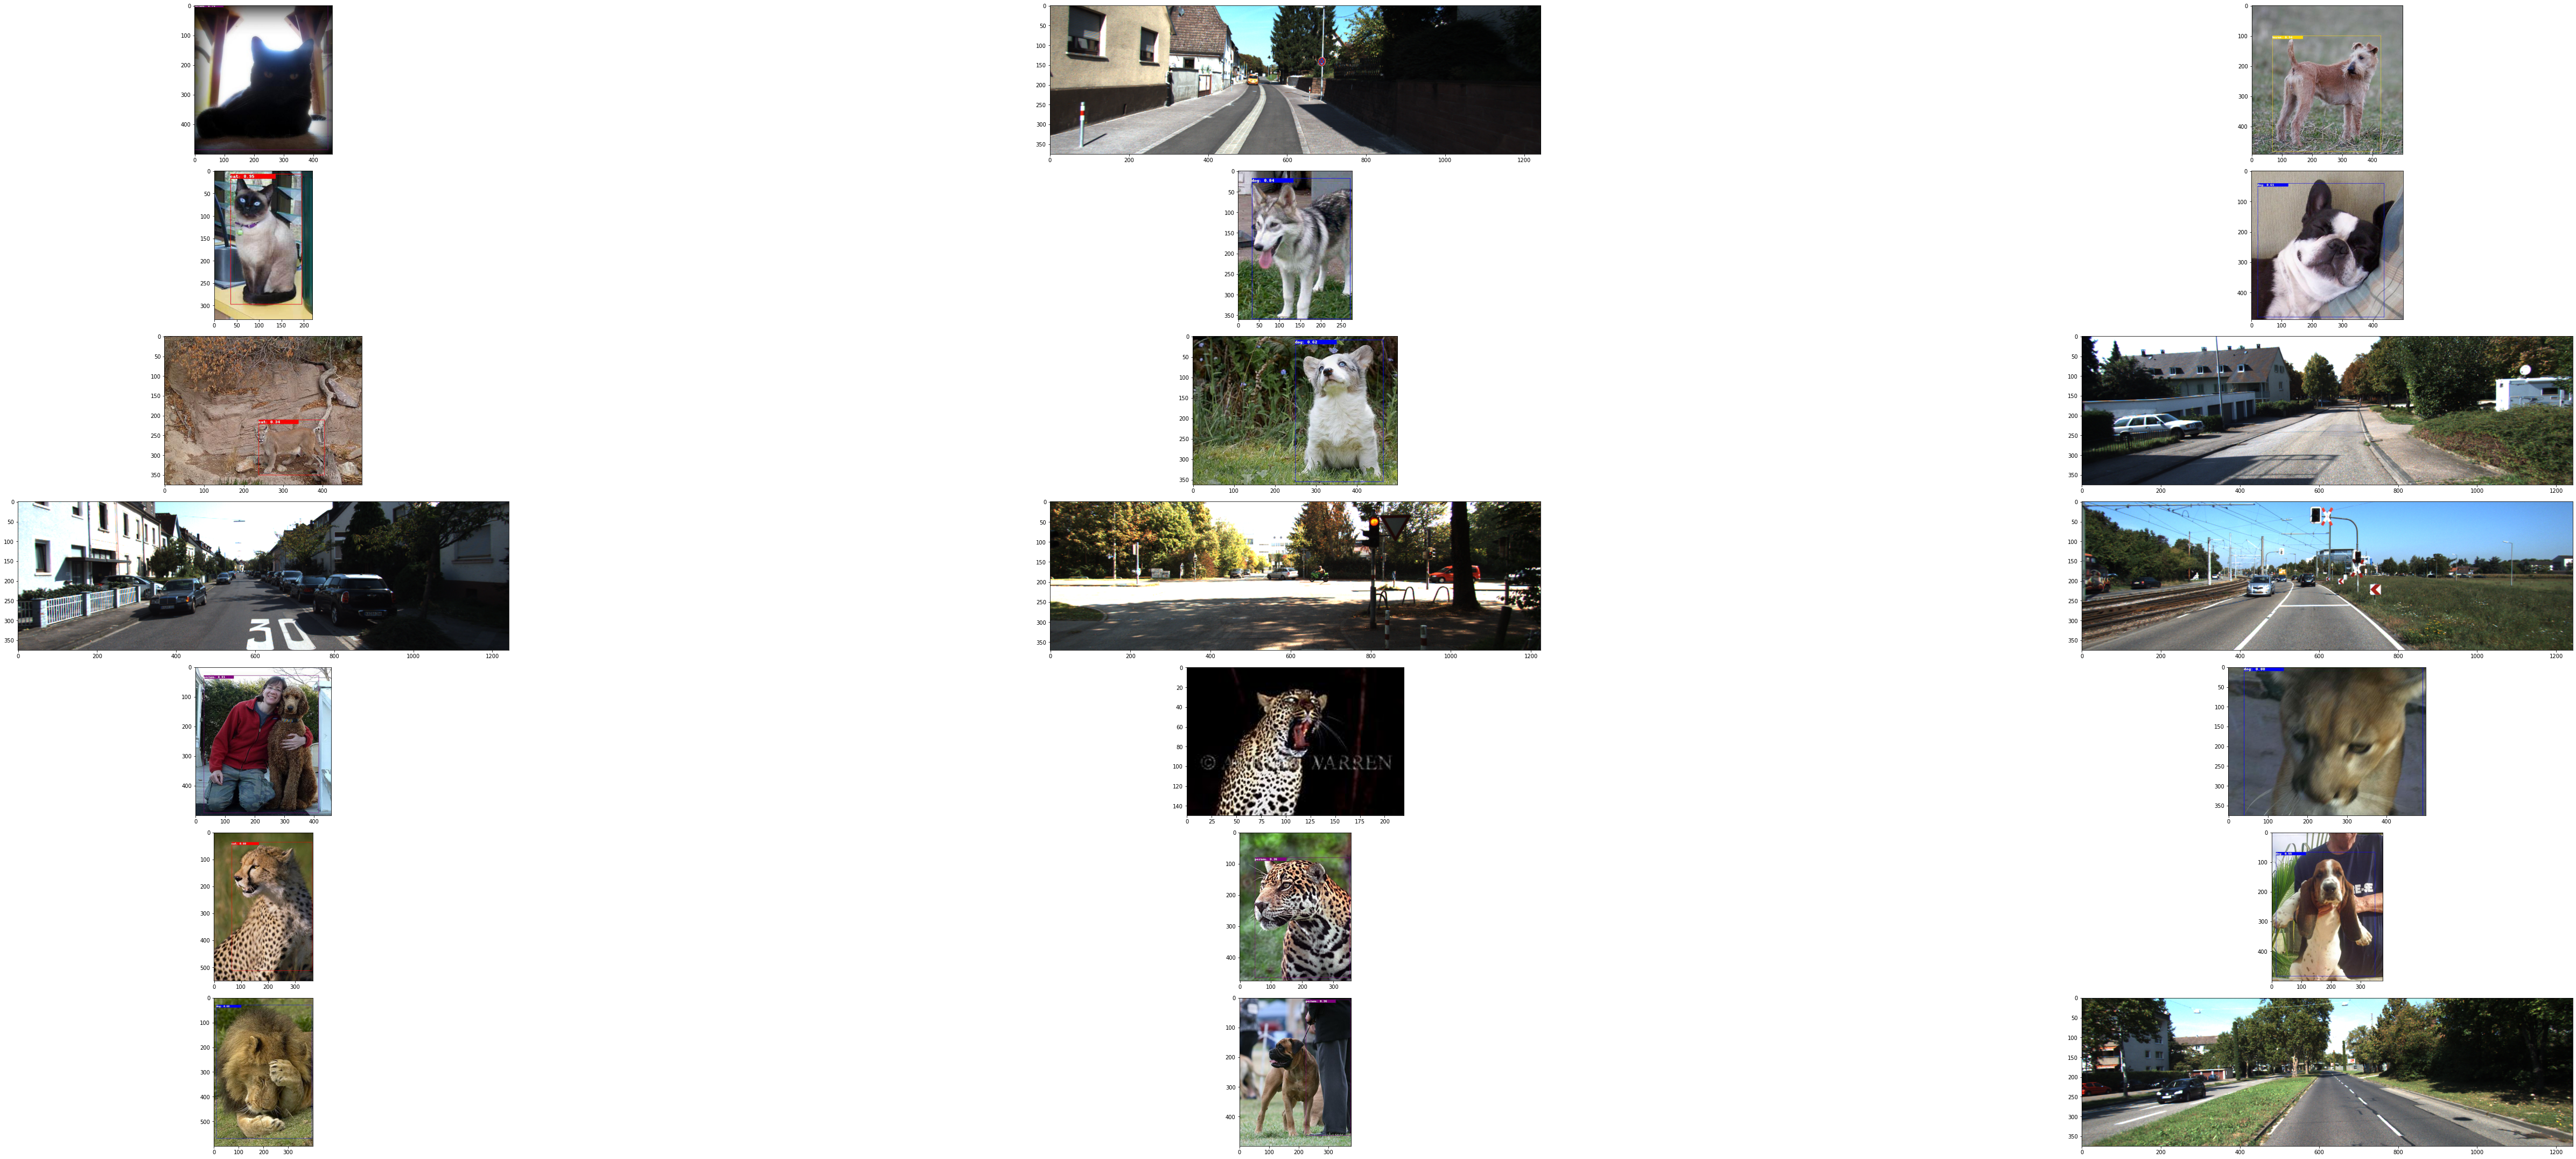

In [60]:
# 下面路径需要输入“绝对路径”，请自行修改
OUTPUT_PATH ='/home/user/hackathon/tao/ssd_cn/ssd_infer_images'
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 21 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## C29. 模型导出 <a class="anchor" id="head-10"></a>
通过tao工具导出您训练的模型，导出的模型可以利用NVIDIA TensorRT或者NVIDIA Deepstream进行推理部署：<br>
**首先确认您要执行推理的设备是否具备INT8与QAT能力**，如果不具备请选择FP16或FP32<br>
* `-m`定义了您要导出的模型
* `-k`定义了您的秘钥API Key
* `-o` 定义了您导出的模型存放的位置
* `-e`定义了您训练这个模型的设置文件
* `--batch_size`定义了模型的输入batchsize
* `--data_type`定义了您导出的模型的数据类型，可以定义为fp32，fp16 or int8。 如果定义了int8 您还需要定义下面的量化文件。

In [ ]:
# tao <task> export will fail if .etlt already exists. So we clear the export folder before tao <task> export
!rm -rf $LOCAL_EXPERIMENT_DIR/export
!mkdir -p $LOCAL_EXPERIMENT_DIR/export
# Export in FP32 mode. Change --data_type to fp16 for FP16 mode
!tao ssd export --gpu_index=$GPU_INDEX \
                -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt \
                -k $KEY \
                -o $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt \
                -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
                --batch_size 1 \
                --data_type fp32

# Uncomment to export in INT8 mode (generate calibration cache file).
# !tao ssd export --gpu_index=$GPU_INDEX \
#                 -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt  \
#                 -o $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt \
#                 -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
#                 -k $KEY \
#                 --cal_image_dir  $USER_EXPERIMENT_DIR/data/testing/image_2 \
#                 --data_type int8 \
#                 --batch_size 16 \
#                 --batches 10 \
#                 --cal_cache_file $USER_EXPERIMENT_DIR/export/cal.bin  \
#                 --cal_data_file $USER_EXPERIMENT_DIR/export/cal.tensorfile

2021-11-12 10:10:56,910 [INFO] root: Registry: ['nvcr.io']
2021-11-12 10:10:57,077 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/user0/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-12 02:11:10,566 [INFO] iva.common.export.keras_exporter: Using input nodes: ['Input']
2021-11-12 02:11:10,566 [INFO] iva.common.export.keras_exporter: Using output nodes: ['NMS']
2021-11-12 02:11:10,567 [INFO] iva.ssd.utils.spec_loader: Merging specification from /workspace/tao-experiments/ssd_cn/specs/ssd_retrain_resnet18_kitti.txt


`Note:` In this example, for ease of execution we restrict the number of calibrating batches to 10. TAO Toolkit recommends the use of at least 10% of the training dataset for int8 calibration.

If you train a QAT model, you may only export in INT8 mode using following code block. This generates an etlt file and the corresponding calibration cache. You can throw away the calibration cache and just use the etlt file in tao-converter or DeepStream for FP32 or FP16 mode. But please note this gives sub-optimal results. If you want to deploy in FP32 or FP16, you should disable QAT in training.

In [ ]:
# Uncomment to export QAT model in INT8 mode (generate calibration cache file).
# !rm -rf $LOCAL_EXPERIMENT_DIR/export
# !mkdir -p $LOCAL_EXPERIMENT_DIR/export
# !tao ssd export --gpu_index=$GPU_INDEX \
#                 -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt  \
#                 -o $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt \
#                 -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
#                 -k $KEY \
#                 --data_type int8 \
#                 --cal_cache_file $USER_EXPERIMENT_DIR/export/cal.bin

In [ ]:
print('Exported model:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/export

在这里利用tao-converter工具将您训练的模型转化为TensorRT可以直接使用的推理引擎，注意：您需要在哪里使用您的模型，您就要在哪里转换这个模型。  
您可以访问下面的地址，下载tao-converter工具：  
https://docs.nvidia.com/tao/tao-toolkit/text/tensorrt.html#tao-converter-matrix

特别注意：这里要下载你的使用环境版本的tao-converter

In [73]:
# Convert to TensorRT engine (FP32)
!tao converter -k $KEY \
                   -d 3,300,300 \
                   -o NMS \
                   -e $USER_EXPERIMENT_DIR/export/trt.engine \
                   -m 1 \
                   -t fp32 \
                   -i nchw \
                   $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt

# Convert to TensorRT engine (FP16)
# !tao converter -k $KEY \
#                    -d 3,300,300 \
#                    -o NMS \
#                    -e $USER_EXPERIMENT_DIR/export/trt.engine \
#                    -m 16 \
#                    -t fp16 \
#                    -i nchw \
#                    $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt

# Convert to TensorRT engine (INT8).
# !tao converter -k $KEY  \
#                    -d 3,300,300 \
#                    -o NMS \
#                    -c $USER_EXPERIMENT_DIR/export/cal.bin \
#                    -e $USER_EXPERIMENT_DIR/export/trt.engine \
#                    -b 8 \
#                    -m 16 \
#                    -t int8 \
#                    -i nchw \
#                    $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt

2021-10-28 12:23:23,499 [INFO] root: Registry: ['nvcr.io']
2021-10-28 12:23:23,617 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the "/home/hekun/.tao_mounts.json" file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
[INFO] Detected 1 inputs and 2 output network tensors.
2021-10-28 12:24:26,847 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


In [ ]:
print('Exported engine:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/export/trt.engine

## C210. 验证导出的模型 <a class="anchor" id="head-11"></a>
验证导出的推理引擎是否能在TensorRT中部署成功，这步不是必须的，可以在您使用的设备上验证

In [ ]:
!tao ssd inference --gpu_index=$GPU_INDEX \
                   -m $USER_EXPERIMENT_DIR/export/trt.engine \
                   -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
                   -i $DATA_DOWNLOAD_DIR/test_samples \
                   -o $USER_EXPERIMENT_DIR/ssd_infer_images \
                   -t 0.4

In [ ]:
# Visualizing the sample images.
OUTPUT_PATH = 'ssd_infer_images' # relative path from $USER_EXPERIMENT_DIR.
COLS = 3 # number of columns in the visualizer grid.
IMAGES = 9 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)